## **VAR - Génération d'images par prédiction de la résolution suivante - Démonstration**

Le principe de ce générateur d'image est de concevoir un modèle autorégressif, qui générera une image à partir de tokens provenant d'un espace-latent, non pas sur le principe de "next-token" mais sur le principe de "next-scale". 

Ce nouveau modèle "VAR" vient challenger les modèles de diffusion en s'inspirant des modèles autorégressifs type chatGPT mais plus adaptés à la structure des images.

L'idée est qu'un Variational AutoEncoder est d'abord entraîné sur un set d'images. On lui apprend à encoder une image sous forme de tokens, puis à la décoder à partir de cet espace latent pour renvoyer cette même image. 

Ensuite, on entraîne un transformer à générer des images à partir de tokens provenant de l'espace latent de l'autoencodeur. La différence majeure avec les générateurs autorégressifs dit "classiques" est qu'au lieu de générer un token après un token, on va générer des ensembles $ r_{k}$ de tokens de plus en plus grand, en générant les tokens d'un même ensemble en parallèle. C'est ce qu'on appelle le "next-scale" ou "résolution suivante". On associe ces ensembles de tokens de plus en plus grands à des résolutions de l'image de plus en plus précises. 


<br><div style="text-align:center"><img style="width:600px;height:auto;" src="images/VAR-scale.png"></img></div><br>

Cette démonstration a pour but de découper les grands principes de VAR en étapes simplifiées pour comprendre l'architecture "next-scale". Les performances ne sont donc pas du tout à la hauteur de ce qui est obtenu par le papier de recherche. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Import du dataset

Utilisation du dataset Cifar-10, plus petit que Image NET

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

100%|██████████| 170M/170M [00:06<00:00, 26.5MB/s] 


# VQ-VAE

Un VQ-VAE est un auto-encodeur variationnel avec quantification vectorielle.
On va d'abord encoder une image d'entrée à l'aide de l'encodeur. Il produit une représentation continue de l'image dans un espace latent. 

Cette représentation est ensuite discrétisée par le quantifieur (Vector quantizer): chaque vecteur de l'espace latent est associé au vecteur le plus proche d'un dictionnaire de vecteurs appris, appelé codebook. 

Pour respecter l'idée du "next-scale", cette discrétisation se fait au sein d'une boucle sur les résolutions, de plus grossier au plus fin.
Lors de la première étape, l'image issue de l'espace latent est redimensionnée à une résolution faible. Cette version "grossière" de l'image est quantifiée par le Vector Quantizer en un premier ensemble de tokens: $r_{1}$
Cette ensemble de tokens est ensuite remis à la résolution finale, projeté sur l'espace latent, et soustrait à la représentation latente de l'image. On ne garde que le résidu de l'image, de manière à n'analyser ensuite que les informations restantes, pas encore capturées.  

L'échelle suivante va donc de la même manière, quantifier les informations restantes, créer le prochain ensemble de tokens $r_{k}$, etc 

A la fin du processus, on a l'ensemble des $r_{K}$ ensembles de tokens. On les projette tous à la résolution finale, leurs contributions sont additionnées, et passées dans le décodeur. 


<br><div style="text-align:center"><img style="width:600px;height:auto;" src="images/VQVAE.png"></img></div><br>

In [ ]:
## Encodeur convolutionnel

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, latent_dim, 1)
        )
    def forward(self, x): return self.net(x)

## Décodeur convolutionnel

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 3, 1),
            nn.Tanh()
        )
    def forward(self, z): return self.net(z)

## Quantifieur de vecteurs

class VectorQuantizer(nn.Module):
    def __init__(self, num_codes, code_dim, beta=0.25):
        super().__init__()
        self.num_codes = num_codes
        self.code_dim = code_dim
        self.codebook = nn.Embedding(num_codes, code_dim)
        nn.init.uniform_(self.codebook.weight, -1.0, -1.0)
        self.beta = beta
    def forward(self, z):
        B, C, H, W = z.shape
        z_flat = z.permute(0,2,3,1).reshape(-1, C)

        # Calcul de la distance entre notre vecteur et les vecteurs du codebook
        dist = (
            z_flat.pow(2).sum(1, keepdim=True)
            - 2 * z_flat @ self.codebook.weight.t()
            + self.codebook.weight.pow(2).sum(1)
        ) 

        # Choix du vecteur le plus proche dans le codebook
        idx = dist.argmin(1) 
        z_q = self.codebook(idx).view(B, H, W, C).permute(0,3,1,2)
        loss = F.mse_loss(z_q.detach(), z) + self.beta * F.mse_loss(z_q, z.detach())
        z_q = z + (z_q - z).detach()

        # Retourne le vecteur du codebook, et la loss associée
        return z_q, loss, idx.view(B, H*W) 

class VQVAE(nn.Module):
    def __init__(self, latent_dim=256, num_codes=2048):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.quantizer = VectorQuantizer(num_codes, latent_dim)
        self.decoder = Decoder(latent_dim)

        # On choisit des résolutions de plus en plus grandes 
        self.scales = [(2, 2), (4, 4), (8, 8)] 

        # Couches de convolution par résolution 
        self.phis = nn.ModuleList([
            nn.Conv2d(latent_dim, latent_dim, 1)
            for _ in self.scales
        ]) 

    def forward(self, x):
      
        f = self.encoder(x)      
        residual = f
        tokens = []
        vq_loss_total = 0.0

        # Algorithme 1 : Quantifieur multi-scale
        for k, (h, w) in enumerate(self.scales):

            # On dimensionne le résidu à une résolution plus faible
            f_k = F.interpolate(residual, size=(h, w), mode="nearest")

            # Quantification sous forme de tokens
            z_q, vq_loss, idx = self.quantizer(f_k)
            vq_loss_total += vq_loss
            tokens.append(idx.view(x.size(0), h * w))

            # On revient à la résolution finale et on enlève le vecteur actuel du résidu
            z_up = F.interpolate(z_q, size=(8, 8), mode="nearest")
            residual = residual - self.phis[k](z_up)

        # Algorithme 2: Reconstruction 
        f_hat = 0
        for k, idx in enumerate(tokens):

            # On récupère la résolution actuelle
            h, w = self.scales[k]

            # Chaque token discret est remplacé par sa représentation continue à partir du codebook 
            z = self.quantizer.codebook(idx).view(
                x.size(0), h, w, -1
            ).permute(0, 3, 1, 2)

            # On repasse à la résolution finale et on additionne les contributions
            z_up = F.interpolate(z, size=(8, 8), mode="nearest")
            f_hat = f_hat + self.phis[k](z_up)

        # On décode la représentation latente
        x_rec = self.decoder(f_hat)

        # Retourne l'image reconstruite, la loss totale, et la liste des ensembles de tokens [r1, r2, ... rK]
        return x_rec, vq_loss_total, tokens



# Entraînement du VQ-VAE

On effectue que 5 epochs pour l'entraînement pour réduire le temps d'exécution. On récupère la sortie du VQ-VAE (image + loss) pour calculer la loss totale et entraîner le modèle.

In [ ]:
# Apple Silicon Support
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
# NVIDIA GPU
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
# Fallback to CPU
else:
    device = torch.device("cpu")

vqvae = VQVAE().to(device)
opt_vq = torch.optim.Adam(vqvae.parameters(), lr=2e-4)

for epoch in range(5):
    for x, _ in dataloader:
        x = x.to(device)
        x_rec, vq_loss, _ = vqvae(x)
        loss = F.mse_loss(x_rec, x) + vq_loss
        opt_vq.zero_grad(); loss.backward(); opt_vq.step()
    print(f"VQ-VAE Epoch {epoch}: loss={loss.item():.4f}")

VQ-VAE Epoch 0: loss=0.2654
VQ-VAE Epoch 1: loss=0.2751
VQ-VAE Epoch 2: loss=0.2600
VQ-VAE Epoch 3: loss=0.2302
VQ-VAE Epoch 4: loss=0.2437


# Visualisation de la reconstruction d'images par le VQ-VAE

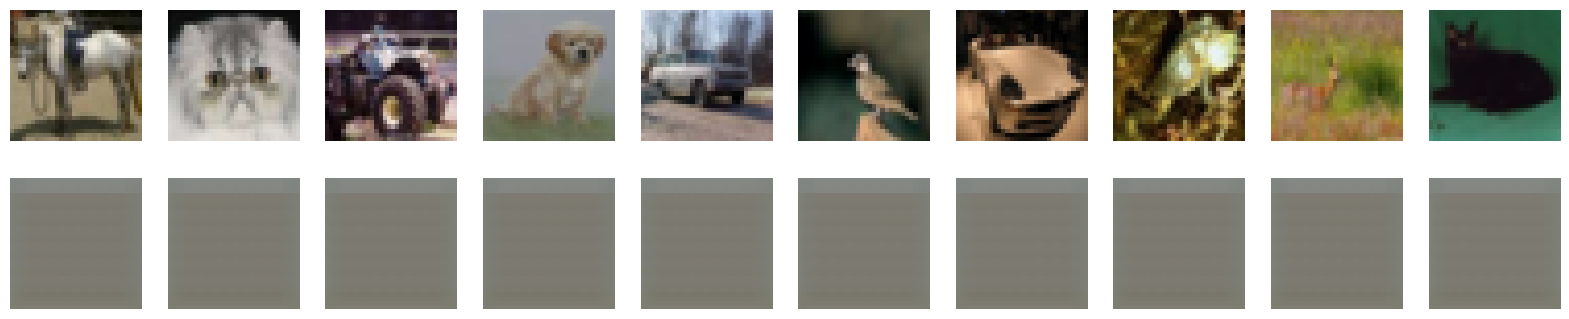

In [5]:
def show_images(orig, recon, n=4):
    """Affiche n images originales et reconstruites côte à côte"""
    plt.figure(figsize=(2*n,4))
    for i in range(n):
        # image originale
        plt.subplot(2,n,i+1)
        plt.imshow(((orig[i].cpu()+1)/2).permute(1,2,0))
        plt.axis('off')
        if i==0: plt.ylabel("Original")
        # image reconstruite
        plt.subplot(2,n,i+1+n)
        plt.imshow(((recon[i].detach() + 1) / 2).permute(1, 2, 0).cpu())
        plt.axis('off')
        if i==0: plt.ylabel("Reconstruction")
    plt.show()

show_images(x, x_rec, n=10)

Les images obtenues sont uniformes car en 5 epochs, le modèle n'a pas eu le temps d'apprendre correctement, et il faudrait beaucoup plus de ressources pour pouvoir l'entraîner correctement.
Pour obtenir des images mieux reproduites, on peut utiliser un VQVAE classique et pas "next-scale", mais l'idée ici était de montrer l'architecture de code proposée par le papier. 

# Construction des séquences de tokens par résolution

Le transformer type VAR prendra en entrée la séquence de tokens $[r_{1}, r_{2}, ..., r_{K}]$. 
On récupère donc les tokens issus du VQ-VAE, et on ajoute un token bos en début de séquence. Ce token est un point de départ explicite pour la génération d'image. 

In [6]:
token_sequences = []

with torch.no_grad():
    # Boucle sur les données
    for i, (x, _) in enumerate(dataloader):

        # On affiche le batch actuel pour suivre la création des séquences de tokens.
        print(i, flush=True)
        x = x.to(device)

        # On récupère les tokens du VQ-VAE et on les met sous forme de séquence
        _, _, tokens = vqvae(x)   
        r1, r2, r3 = tokens      
        seq = torch.cat([r1, r2, r3], dim=1)  

        # Création du token bos
        bos = torch.full(
            (seq.size(0), 1),
            512,
            device=seq.device,
            dtype=seq.dtype
        )

        # Ajout du bos à la séquence de tokens
        seq = torch.cat([bos, seq], dim=1)  
        token_sequences.append(seq)

token_sequences = torch.cat(token_sequences).cpu()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Masque d'attention

Le principe "next-scale" est que tous les tokens d'un ensemble de tokens d'une résolution spécifique sont générés en parallèle. Au sein d'une même résolution, les tokens ne doivent donc pas "se voir" entre eux. L'attention doit être bloquée. Par contre, ces tokens sont générés en s'appuyant sur tous les tokens des résolutions précédentes, l'attention vers les résolutions précédentes sont donc autorisées.

Lorsque l'attention est autorisée, le masque sera sur False (car pas nécessaire d'avoir un masque), et lorsque que l'attention sera interdite, il sera sur True (car il faut un masque).

In [7]:
def build_var_mask(seq_len, splits):
    
    T = seq_len
    mask = torch.ones(T, T, dtype=torch.bool)

    # Le token BOS ne reçoit aucune information, mais tous les tokens peuvent le voir
    mask[:, 0] = False
    mask[0, :] = True

    # Boucle sur les résolutions

    for k, (s_k, e_k) in enumerate(splits):
        s_k += 1
        e_k += 1

        # Bloc d'attention à l'intérieur d'une résolution: attention interdite
        mask[s_k:e_k, s_k:e_k] = True

        # Bloc d'attention envers les résolutions précédentes: attention autorisée
        for j in range(k):
            s_j, e_j = splits[j]
            s_j += 1
            e_j += 1
            mask[s_k:e_k, s_j:e_j] = False

    return mask


# Mini-transformer de génération à l'échelle suivante

Le transformer va prédire les ensembles de tokens résolution par résolution. 

In [8]:
class MiniVAR(nn.Module):
    def __init__(self, vocab_size=513, seq_len=80, dim=256, depth=6, heads=8):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, dim)
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, dim))

        # Création des blocs transformer
        self.blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(dim, heads, dim*4, batch_first=True)
            for _ in range(depth)
        ])
        self.ln = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, vocab_size)

        # On définit les positions de chaque ensemble de tokens: les tokens de r1 sont les 4 (2x2) premiers, puis on a ensuite 16 (4x4) tokens de r2, etc
        splits = [(0,4),(4,20),(20,84)]

        # Construction du masque d'attention
        self.register_buffer("mask", build_var_mask(seq_len, splits))


    def forward(self, x, src_mask=None):
        T = x.size(1)

        # Embedding: les tokens sont transformés en vecteurs continus
        h = self.tok_emb(x) + self.pos_emb[:, :T]

        mask = self.mask[:T, :T]

        # chaque bloc transformer encode les tokens en tenant compte des dépendances imposées par le masque
        for block in self.blocks:
            h = block(h, src_mask=mask)
            
        return self.head(self.ln(h))

# Entraînement du transformer

## Calcul de la loss


In [9]:
def var_loss(logits, targets, splits):
   
    loss = 0.0
    count = 0

    # Boucle sur les résolutions
    for (s, e) in splits:
        s += 1
        e += 1

        # On prédit la résolution suivante à partir des précédentes
        logits_k = logits[:, s:e]
        targets_k = targets[:, s:e]

        # Calcul de la loss associée à la résolution actuelle
        loss_k = F.cross_entropy(
            logits_k.reshape(-1, logits.size(-1)),
            targets_k.reshape(-1)
        )

        loss += loss_k
        count += 1

    # Retourne la loss moyenne entre résolutions
    return loss / count


## Entraînement

In [10]:
miniVAR = MiniVAR(seq_len=85).to(device)
opt = torch.optim.AdamW(miniVAR.parameters(), lr=3e-4)

splits = [(0, 4), (4, 20), (20, 84)]

for epoch in range(5):
    for batch in token_sequences.split(128):
        batch = batch.to(device)

        logits = miniVAR(batch)

        loss = var_loss(logits,batch,splits)
        opt.zero_grad(); loss.backward(); opt.step()
    print(f"Transformer Epoch {epoch}: loss={loss.item():.4f}")

Transformer Epoch 0: loss=0.0027
Transformer Epoch 1: loss=0.0009
Transformer Epoch 2: loss=0.0005
Transformer Epoch 3: loss=0.0003
Transformer Epoch 4: loss=0.0002


# Générateur d'images

A partir des logits renvoyés par le transformer VAR, on va pouvoir générer une image. On crée le générateur d'images qui va générer successivement les tokens de chaque résolution. On gardera la résolution finale pour générer l'image.

In [23]:
@torch.no_grad()
def generate_image(
    miniVAR,
    vqvae,
    device,
    temperature=1.0,
    top_k=None
):
    miniVAR.eval()
    vqvae.eval()

    

    # Création du token BOS
    BOS = 512
    tokens = torch.tensor([[BOS]], device=device)  

    
    ## Génération du premier ensemble de tokens r1 de 4 tokens (2x2)

    # On récupère les logits du miniVAR
    logits = miniVAR(tokens)[:, -1]          
    logits = logits / temperature

    if top_k is not None:
        v, _ = torch.topk(logits, top_k)
        logits[logits < v[:, [-1]]] = -float("inf")

    # On génère les tokens de r1 à partir des logits
    r1 = torch.multinomial(
        torch.softmax(logits, dim=-1),
        num_samples=4
    )                                       

    # On ajoute les tokens de r1 à la liste des tokens
    tokens = torch.cat([tokens, r1], dim=1)

   ## Génération du 2ème ensemble de tokens r2 de 16 tokens (4x4)
    logits = miniVAR(tokens)[:, -1]           
    logits = logits / temperature

    if top_k is not None:
        v, _ = torch.topk(logits, top_k)
        logits[logits < v[:, [-1]]] = -float("inf")

    r2 = torch.multinomial(
        torch.softmax(logits, dim=-1),
        num_samples=16
    )                                       

    tokens = torch.cat([tokens, r2], dim=1)

    ## Génération du 3ème ensemble de tokens r3 de 64 tokens (8x8)
    logits = miniVAR(tokens)[:, -1]           
    logits = logits / temperature

    if top_k is not None:
        v, _ = torch.topk(logits, top_k)
        logits[logits < v[:, [-1]]] = -float("inf")

    r3 = torch.multinomial(
        torch.softmax(logits, dim=-1),
        num_samples=64
    )                                       

    
    ## Reconstruction de l'image avec le décodeur du VQ-VAE
    z = r3.view(1, 8, 8)
    z_q = vqvae.quantizer.codebook(z)
    z_q = z_q.permute(0, 3, 1, 2).contiguous()
    img = vqvae.decoder(z_q)


    return img


# Visualisation de l'image générée



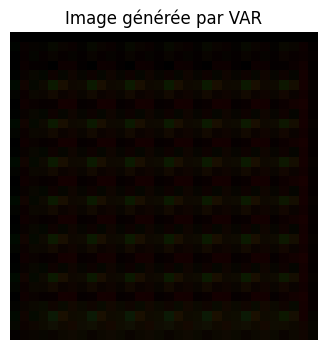

In [ ]:
# Génération de l'image
img = generate_image(
    miniVAR=miniVAR,
    vqvae=vqvae,
    device=device,
    temperature=1.0,
    top_k=None
)

img = img.clamp(0, 1).cpu()
img_np = img[0].permute(1, 2, 0).numpy()

plt.figure(figsize=(4, 4))
plt.imshow(img_np)
plt.axis("off")
plt.title("Image générée par VAR")
plt.show()



Encore une fois, on obtient une image homogène car le VQ VAE "next-scale" n'est pas entraîné correctement.